In [1]:
import pandas as pd    
import numpy as np

data = pd.read_csv("data/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [2]:
# class to extract sentences

class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)

sentences = getter.sentences

  Using cached https://files.pythonhosted.org/packages/c3/8b/af9e0984f5c0df06d3fab0bf396eb09cbf05f8452de4e9502b182f59c33b/matplotlib-3.1.1-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/11/fa/0160cd525c62d7abd076a070ff02b2b94de589f1a9789774f17d7c54058e/pyparsing-2.4.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/df/93/8bc9b52a8846be2b9572aa0a7c881930939b06e4abe1162da6a0430b794f/kiwisolver-1.1.0-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl


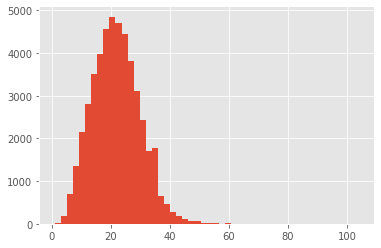

In [4]:
# !pip install matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.hist([len(s) for s in sentences], bins=50)
plt.show()

For the use of neural nets (at least with keras, this is no theoretical reason) we need to use equal-lenght input sequences. So we are going to pad our sentences to a length of 50. But first we need dictionaries of words and tags.

In [5]:
max_len = 50

words = list(set(data["Word"].values))
words.append("ENDPAD")

tags = list(set(data["Tag"].values))

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [13]:
# !pip install keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=len(words) - 1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=len(tags)) for i in y]

In [14]:
# split train and test
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

Now we can fit a LSTM network with an embedding layer

In [19]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Embedding(len(words), 50, input_length = max_len))
model.add(keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(tags), activation="softmax")))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
38846/38846 [==============================] - 100s 3ms/sample - loss: 0.1781 - accuracy: 0.9588 - val_loss: 0.0654 - val_accuracy: 0.9811
Epoch 2/5
38846/38846 [==============================] - 98s 3ms/sample - loss: 0.0509 - accuracy: 0.9849 - val_loss: 0.0503 - val_accuracy: 0.9845
Epoch 3/5
38846/38846 [==============================] - 99s 3ms/sample - loss: 0.0374 - accuracy: 0.9885 - val_loss: 0.0472 - val_accuracy: 0.9857
Epoch 4/5
38846/38846 [==============================] - 95s 2ms/sample - loss: 0.0311 - accuracy: 0.9902 - val_loss: 0.0463 - val_accuracy: 0.9859
Epoch 5/5
38846/38846 [==============================] - 97s 3ms/sample - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.0471 - val_accuracy: 0.9858


In [22]:
hist = pd.DataFrame(history.history)

In [27]:
# !pip install plotly
# !pip install cufflinks
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot 
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

hist[['accuracy', 'val_accuracy']].iplot(
    kind='line',
    xTitle='Iteration',
    yTitle='Acc',
    title='Review Rating Distribution')

In [46]:
import random

i = random.randint(0, X_te.shape[0])
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
The            : O
Lahore         : B-org
High           : I-org
Court          : I-org
ruled          : O
Monday         : B-tim
that           : O
Mr.            : B-per
Sharif         : I-per
is             : O
not            : O
qualified      : O
to             : O
run            : O
in             : O
Thursday       : B-tim
's             : O
election       : O
because        : O
of             : O
convictions    : O
related        : O
to             : O
his            : O
overthrow      : O
in             : O
a              : O
1999           : B-tim
military       : O
coup           : O
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD 